In [1]:
import time
import os
import numpy as np
import re
import json
import torch
import torch.nn
from torch.utils.data import random_split
from utils import EloGuessrDset
torch.manual_seed(33)

In [2]:
data_dir = '/Home/siv33/vbo084/EloGuessr/data/raw/'

# Functions for loading and extracting features

In [3]:
'''
Function for doing an initial cleanup.
Gets rid of games missing ELO values,
Bullet and Variant games, games with
Stockfish evals and games played by
correspondence.
'''

def initial_cleanup(game_list):
    
    wo_bullet = []
    game_list_len = len(game_list)
    
    print(f'The initial dataset has length {game_list_len}')
    
    # Gets rid of games with Bullet time control, empty games, and short games
    for game in game_list:
        if game.count('Bullet') > 0:
            del game
            continue
        if game.count('Variant') > 1:
            del game
            continue
        elif game.count('Result') == 0:
            del game
            continue
        elif game.count('eval') > 0:
            del game
            continue
        elif game.count('6.') == 0:
            del game
            continue
        elif game.count('[WhiteElo "?"]') > 0:
            del game
            continue
        elif game.count('[BlackElo "?"]') > 0:
            del game
            continue
        elif game.count('Correspondence') > 0:
            del game
            continue
        else:
            wo_bullet.append(game)
    
    print(f'The length after cleanup is of {len(wo_bullet)}')
    print(f'We have pruned {game_list_len - len(wo_bullet)} games!')
    
    return wo_bullet

In [4]:
def result_to_int(results_list):
    
    int_results = []
    
    for result in results_list:
        if result.count("White") > 0:
            result = 0
        elif result.count("Black") > 0:
            result = 1
        else:
            result = 2
        
        int_results.append(result)
        
    return np.array(int_results)

In [5]:
'''
Function for feature extraction and final cleanup.
First returns the game as a string of moves.
Then returns who won the game or if it was a draw,
and returns the ELO of both players.
'''

def feature_extraction(game_list: list) -> np.array:
    
    faulty = []
    elo = []
    results = []
    game_features = []
    game_moves = []

    draws = 0
    black_wins = 0
    white_wins = 0
    
    # Transforms the game into its final str representation format.
    for game in game_list:
        
        features = game[:game.find("\n\n1.")].strip()
        game_features.append(features)
        final_game = game[game.find("\n\n1."):]
        
        if final_game.find("1-0") > 0:
            final_game = final_game[final_game.find("1."):final_game.find("1-0")]
        
        elif final_game.find("0-1") > 0:
            final_game = final_game[final_game.find("1."):final_game.find("0-1")]
        
        elif final_game.find("1/2") > 0:
            final_game = final_game[final_game.find("1."):final_game.find("1/2")]
        
        game_moves.append(final_game.strip())

    # We get the mean ELO for the match
    # We make the simplifying (yet justified) assumption that matches have players with similar ELO scores

    for game in game_features:
        
        index1 = game.find("[WhiteElo")
        index2 = game.find("[WhiteRatingDiff")
        
        game = game[index1:index2]
        
        score = re.findall('\\d+', game)[:2]
        White_Elo = float(score[0])
        Black_Elo = float(score[1]) 
        mean_elo = (White_Elo + Black_Elo)/2
        elo.append(mean_elo)

    # Gets the game result (who won or whether it was a draw)
    for i, game in enumerate(game_features):
        
        index = game.find('Result')+8
        victory = game[index:index+2]

        if victory == "1-":
            results.append('[WHITE]')
            white_wins += 1
        elif victory == "0-":
            results.append('[BLACK]')
            black_wins += 1
        elif victory == "1/":
            results.append('[DRAW]')
            draws += 1
        else:
            faulty.append(i)
            elo.pop(i)
            game_moves.pop(i)

    for i, moves in enumerate(game_moves):
        # game_moves[i] = moves + ' ' + results[i] + ' [ELO]'
        game_moves[i] = moves + ' ' + results[i]
    
    print(f"Clean list length: {len(game_moves)}")
    print(f"Elo list length: {len(elo)}")
    print(f"Results list length: {len(results)}")
    print(f"The games at indexes {faulty} are faulty.")
    print(f'White won {white_wins} times, black won {black_wins} times, and there were {draws} draws.')

    # Returns games, ELO and match results as numpy arrays
    return np.array(game_moves), np.array(elo), np.array(results)

In [6]:
from utils import backlash_remover

def data_loader(path) -> list:
    
    a = time.monotonic()
    
    # Opens the file
    with open(path) as f:
        data = f.read()
    
    # Converts the data into string
    data = str(data)
    
    # Divides the file into games
    raw_games = data.split('[Event')
    del raw_games[0]
    del data
    
    # Gets rid of blitz, correspondence, variants, games without ELO scores, etc
    cleaned_matches = initial_cleanup(raw_games)
    del raw_games
    
    # Returns clean text move strings, pairs of elo, match result (who won)
    clean, elo, _ = feature_extraction(cleaned_matches)
    del cleaned_matches

    clean = backlash_remover(clean)

    # Adds the result of the match as one of special tokens "[BLACK]" or "[WHITE]"
    
    b = time.monotonic()
    print(f'Runtime: {b-a}')
    print('')
    
    return clean, elo

# Loading data and cleaning it up

### Preparing and Mergin Datasets

In [7]:
input_fname = '2014_06.pgn'
input_elite_fname = "elite_2019_06.pgn"
input_elite_fname2 = 'elite_2020_05.pgn'
input_elite_fname3 = 'elite_2022_10.pgn'

In [8]:
elite_clean, elite_elo = data_loader(os.path.join(data_dir, input_elite_fname))
final_clean = elite_clean
final_elo = elite_elo
#elite_clean2, elite_elo2 = data_loader(os.path.join(data_dir, input_elite_fname2))
#elite_clean3, elite_elo3 = data_loader(os.path.join(data_dir, input_elite_fname3))
#clean, elo = data_loader(os.path.join(data_dir, input_fname))

The initial dataset has length 76809
The length after cleanup is of 76793
We have pruned 16 games!
Clean list length: 76788
Elo list length: 76788
Results list length: 76788
The games at indexes [51030, 51040, 51044, 71922, 71923] are faulty.
White won 37055 times, black won 33530 times, and there were 6203 draws.
Runtime: 2.109209117013961



In [9]:
#final_clean = np.concatenate((elite_clean2, clean))
#final_elo = np.concatenate((elite_elo2, elo))

In [10]:
#final_clean = np.concatenate((np.concatenate((elite_clean, elite_clean2)), elite_clean3))
#final_elo = np.concatenate((np.concatenate((elite_elo, elite_elo2)), elite_elo3))

In [11]:
def find_duplicate_indices(games_array):
    unique_games = set()
    duplicate_indices = []

    for i, game in enumerate(games_array):
        if game in unique_games:
            duplicate_indices.append(i)
        else:
            unique_games.add(game)

    return duplicate_indices

In [12]:
duplicate_idcs = find_duplicate_indices(final_clean)
print(len(duplicate_idcs))
final_clean = np.delete(final_clean, duplicate_idcs)
final_elo = np.delete(final_elo, duplicate_idcs)

19


In [13]:
len(final_clean)

76769

# Creating a vocab and tokenizing the dataset

In [14]:
class ChessTokenizer():
    def __init__(self, dataset, specialtks: list):
        self.special_tokens = specialtks
        self.decode_vocab = self.get_vocab(dataset, self.special_tokens)
        self.encode_vocab = {v:k for k,v in self.decode_vocab.items()}

    def get_vocab(self, dataset: list, special_tokens: list) -> dict:
        vocab_freq = {}

        corpus_str = ' '.join(dataset)

        moves = corpus_str.split()
        for move in moves:
            if move in vocab_freq:
                vocab_freq[move] += 1
            else:
                vocab_freq[move] = 1

        filtered_moves = {move: count for move, count in vocab_freq.items() if count >= 1}
        vocab = {i: move for i, move in enumerate(filtered_moves.keys())}
        vocab_len = len(vocab)
        vocab.update({vocab_len + i: token for i, token in enumerate(special_tokens)})

        return vocab

    def encode(self, game: str) -> list:
        encoded_game = [self.encode_vocab.get(move, self.encode_vocab['[UNK]']) for move in game.split()]
        return encoded_game

    def decode(self, game: list) -> str:
        decoded_game = [self.decode_vocab[move] for move in game]
        return decoded_game
    
    def get_dset_distribution(self, encoded_dataset: list) -> dict:
        if not all(isinstance(game, list) and all(isinstance(move, int) for move in game) for game in encoded_dataset):
            raise ValueError('All elements of encoded_dataset must be lists of integers.')
        
        length_distribution = {}
        for game in encoded_dataset:  
            lengame = len(game)
            if lengame not in length_distribution.keys():
                length_distribution[lengame] = 1
            else:
                length_distribution[lengame] += 1

        length_distribution = {key: length_distribution[key] for key in sorted(length_distribution)}

        return length_distribution
    
    def pad_dataset(self, encoded_dataset: list, labels: list, len_distribution: dict) -> np.array:
        
        game_lens = sorted(list(len_distribution.keys()))
        mid_lens = game_lens[int(len(game_lens) * 0):int(len(game_lens) * 1)]
        max_mid = max(mid_lens)
        mid_lens = range(284)
        max_mid = max(mid_lens)
        pad_token = self.encode_vocab['[PAD]']

        padded_dataset = []
        ordered_labels = []

        for i, game in enumerate(encoded_dataset):
            if len(game) in mid_lens:
                padding = [(max_mid - len(game)) * [pad_token]][0]
                padded_game = game + padding
                padded_dataset.append(padded_game)
                ordered_labels.append(labels[i])

        return np.array(padded_dataset), np.array(ordered_labels)

In [15]:
special_tokens = ["[UNK]", "[PAD]", "[BLACK]", "[WHITE]", "[DRAW]", "[ELO]"]
tokenizer = ChessTokenizer(final_clean, special_tokens)

# Creating the DataLoaders to train the model

In [16]:
from utils import plot_gameslendist

def create_dataset(tokenizer: ChessTokenizer, dataset_samples: list, dataset_labels: list) -> np.array:

    if not all(isinstance(game, str) for game in dataset_samples):
        raise ValueError('The elements of dataset_samples must be of type string.')
    
    encoded_dataset = [(tokenizer.encode(game)) for game in dataset_samples]

    plot_gameslendist(encoded_dataset=encoded_dataset, num_buckets=10)

    len_distribution = tokenizer.get_dset_distribution(encoded_dataset)
    padded_dset, labels = tokenizer.pad_dataset(encoded_dataset, dataset_labels, len_distribution)

    return padded_dset, labels

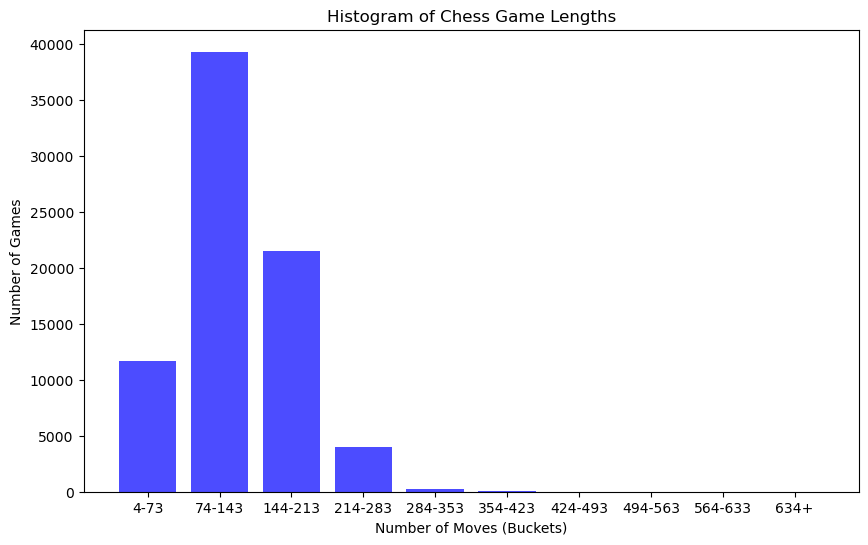

In [17]:
from utils import plot_gameslendist

padded_samples, labels = create_dataset(tokenizer, final_clean, final_elo)

In [18]:
chess_data = EloGuessrDset(padded_samples, labels)

In [19]:
print(len(chess_data))

76582


In [20]:
train_size = int(0.8 * len(chess_data))
val_size = int(0.1 * len(chess_data))
test_size = len(chess_data) - train_size - val_size

In [21]:
specs ={'pad_idx': tokenizer.encode_vocab['[PAD]'],
        'vocab_len': len(tokenizer.decode_vocab.keys()),
        'match_len': len(padded_samples[0])}

print(specs)

{'pad_idx': 6556, 'vocab_len': 6561, 'match_len': 299}


In [22]:
train_dataset, val_dataset, test_dataset = random_split(chess_data, [train_size, val_size, test_size])

In [23]:
processed_data_dir = '/Home/siv33/vbo084/EloGuessr/data/processed/'

specs_dict_path = os.path.join(processed_data_dir + 'chess_elite_medium.json')

# Save the dictionary as a JSON file
with open(specs_dict_path, 'w') as json_file:
    json.dump(specs, json_file, indent=4)

In [24]:
torch.save(train_dataset, os.path.join(processed_data_dir, 'chess_train_elite_medium.pt'))
torch.save(val_dataset, os.path.join(processed_data_dir, 'chess_val_elite_medium.pt'))
torch.save(test_dataset, os.path.join(processed_data_dir, 'chess_test_elite_medium.pt'))